In [1]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import os.path
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import copy

sns.set_palette("bright")
sns.set_style("whitegrid")

In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [3]:
import pyro
import pyro.distributions as dist

from scipy import loadtxt

In [4]:
train_x = torch.from_numpy(
    np.loadtxt("https://raw.githubusercontent.com/cambridge-mlg/expressiveness-approx-bnns/main/datasets/origin/origin_x.txt")
).float().cuda()
train_y = torch.from_numpy(
    np.loadtxt("https://raw.githubusercontent.com/cambridge-mlg/expressiveness-approx-bnns/main/datasets/origin/origin_y.txt")
).float().view(-1,1).cuda()

In [5]:
relu = torch.nn.functional.relu

In [6]:
def model(X, Y, D_H=50):
    
    D_X, D_Y = X.shape[1], 1
    # sample first layer (we put unit normal priors on all weights)
    w1 = pyro.sample("w1", dist.Normal(torch.zeros((D_X, D_H)), 4. * torch.ones((D_X, D_H)) / D_X))  # D_X D_H
    b1 = pyro.sample("b1", dist.Normal(torch.zeros((D_H)), torch.ones((D_H)) / D_X))
    z1 = relu(torch.matmul(X, w1))   # N D_H  <= first layer of activations

#     # sample second layer
#     w2 = pyro.sample("w2", dist.Normal(torch.zeros((D_H, D_H)), torch.ones((D_H, D_H))))  # D_H D_H
#     z2 = relu(torch.matmul(z1, w2))  # N D_H  <= second layer of activations

    # sample final layer of weights and neural network output
    w3 = pyro.sample("w3", dist.Normal(torch.zeros((D_H, D_Y)), 4. * torch.ones((D_H, D_Y)) / D_H))  # D_H D_Y
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(D_Y), torch.ones(D_Y) / D_H))
    z3 = torch.matmul(z1, w3) + b3 # N D_Y  <= output of the neural network

    # we put a prior on the observation noise
    # prec_obs = pyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    # sigma_obs = 1.0 / torch.sqrt(prec_obs)

    # observe data
    return pyro.sample("Y", dist.Normal(z3, 0.1), obs=Y)


In [7]:

nuts_kernel = pyro.infer.NUTS(model, jit_compile=True, max_tree_depth=5)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples = 1000, warmup_steps = 10000)

# train_x, train_y, test_x = get_data()
# train_x, train_y = torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float()
# test_x = torch.from_numpy(test_x).float()

mcmc.run(train_x, train_y)
#hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}



Sample: 100%|██████████| 11000/11000 [23:16,  7.88it/s, step size=6.83e-03, acc. prob=0.886]


In [8]:
buffer = 1.0
h = 0.1
x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

xx,yy=np.meshgrid(np.linspace(x_min.cpu(), x_max.cpu(), 45), 
                  np.linspace(y_min.cpu(), y_max.cpu(), 45))
in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

In [9]:
from pyro.infer import Predictive
predictive_call = Predictive(model, mcmc.get_samples(), num_samples=1000)
pred_samples = predictive_call(in_grid.cuda(), None)

In [10]:
pred = pred_samples["Y"].squeeze(-1)

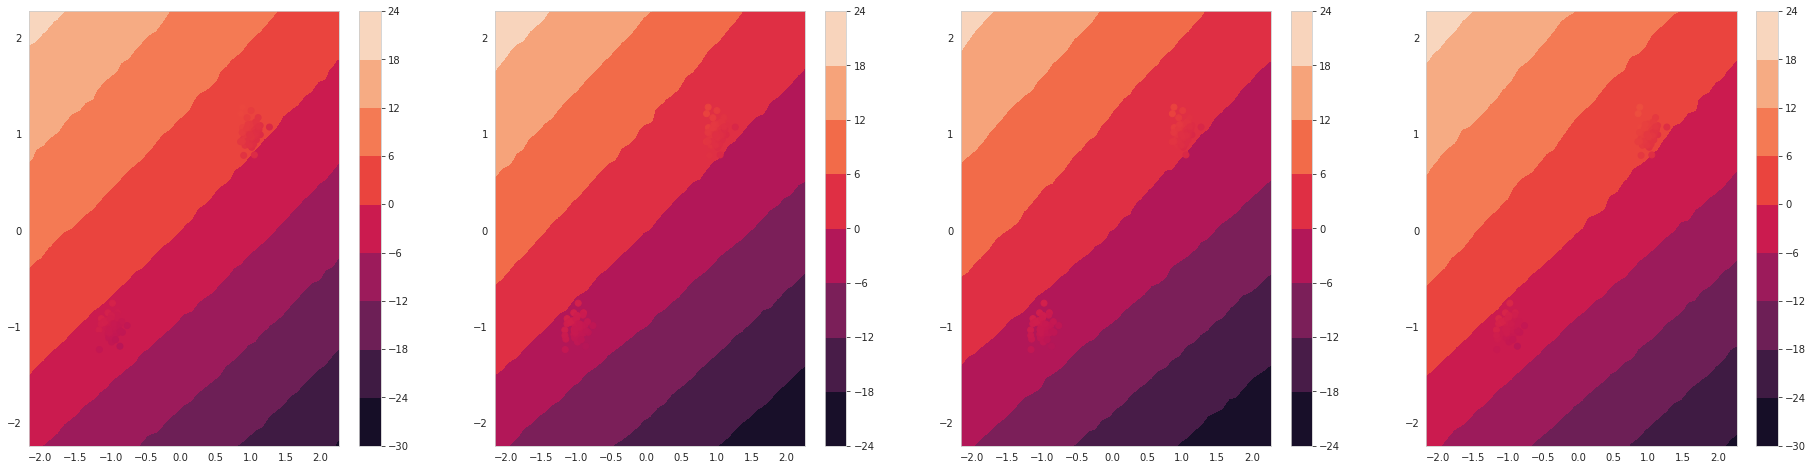

In [11]:
fig, ax = plt.subplots(1, 4, figsize = (32, 8))

for ii, s in enumerate([0, 30, 50, -1]):
    f = ax[ii].contourf(xx, yy, pred[s].detach().reshape(xx.shape).cpu())
    fig.colorbar(f, ax = ax[ii])
    ax[ii].scatter(train_x[:,0].cpu(), train_x[:,1].cpu(), c=train_y.cpu().view(-1), vmin=pred[ii].min(), vmax=pred[ii].max())

Text(0.5, 1.0, '$\\sigma[f(x)]$')

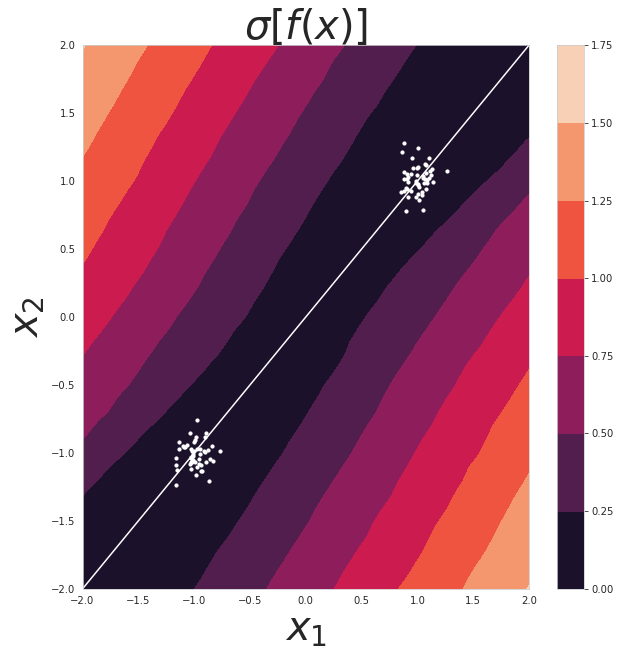

In [12]:
plt.figure(figsize=(10, 10), facecolor="w")
f = plt.contourf(xx, yy, pred.std(dim=0).reshape(xx.shape).cpu())
plt.scatter(train_x[:,0].cpu(), train_x[:,1].cpu(), color = "white", s = 10)
plt.plot(torch.linspace(-2, 2, 100).cpu(), torch.linspace(-2, 2, 100).cpu(), color = "white")
plt.colorbar(f)
plt.ylim((-2, 2))
plt.xlim((-2,2))
plt.xlabel(r"$x_1$", fontsize = 40)
plt.ylabel(r"$x_2$", fontsize = 40)
plt.title(r"$\sigma[f(x)]$", fontsize=40)

In [13]:
test_x = torch.stack((torch.linspace(-2, 2, 300), torch.linspace(-2, 2, 300))).t()

In [14]:
pred = predictive_call(test_x, None)["Y"].squeeze(-1)

Text(0, 0.5, '')

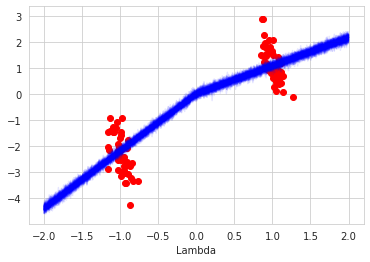

In [15]:
for ii in range(100):
    plt.plot(test_x[:,0].cpu(), pred[ii].detach().cpu(), color = "blue", alpha = 0.1)
plt.scatter(train_x[:,0].cpu(), train_y.cpu(), color = "red")
plt.xlabel("Lambda")
plt.ylabel("")

(-6, 6)

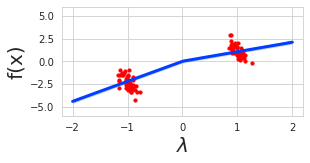

In [17]:
plt.figure(figsize=(4.333, 2), facecolor="w")
plt.plot(test_x[:,0].cpu(), pred.mean(dim=0).detach().cpu(), label="E(y|D)", linewidth=3)
plt.fill_between(test_x[:,0].cpu(), 
                 pred.mean(dim=0).cpu() - 2. * pred.std(dim=0).cpu(), 
                 pred.mean(dim=0).cpu() + 2. * pred.std(dim=0).cpu(), alpha = 0.3, label = "p(y|D)")
plt.scatter(train_x[:,0].cpu(), train_y.cpu(), s=10, color = "red")
plt.xlabel(r"$\lambda$", fontsize = 20)
plt.ylabel("f(x)", fontsize=20)
#plt.legend(fontsize=14)
#plt.grid()
plt.ylim((-6,6))